### Importation des librairies

In [77]:
import pandas as pd
import html
import numpy as np
import string 
import re
import gensim
from gensim.models import CoherenceModel
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
import nltk
from nltk.corpus import stopwords
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.layers import TextVectorization, Input, Embedding, LSTM, Dropout, Dense, Activation
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
import pickle
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models

# Visualisation du corpus

In [81]:
#Extraction du corpus
data={}
with open("corpus.xml","r") as xml : 
    for line in xml : 
        entite_html_decode = html.unescape(line)
        if "<article" in entite_html_decode :
            date = entite_html_decode.split()[1].split('"')[1]
        if "<title>" in entite_html_decode :
            titre = entite_html_decode.split("<title>")[1].split("</title>")[0]
        if "<analyse>" in entite_html_decode : 
            article = []
        if "</analyse>" in entite_html_decode : 
            data_sans_regroupement_par_jour.append(article)
            try : 
                data[date].append(article)
            except : 
                data[date]=[]
                data[date].append(article)
        if "<token" in entite_html_decode :
            token = entite_html_decode.split()[1].split('"')[1]
            article.append(token)

In [82]:
#Data extraite pour une journée
print(data['2022-03-27'])

[['Les', 'spinosaures', ',', 'dinosaures', 'aquatiques', '', 'La', 'densité', 'élevée', 'des', 'os', 'de', 'ces', 'animaux', 'suggère', 'qu’', 'ils', 'profitaient', 'de', 'ce', 'ballast', 'pour', 'se', 'mouvoir', 'dans', 'et', 'sous', 'l’', 'eau', '.'], ['Présidentielle', '2022', '', ':', 'le', 'nucléaire', 'est', '-il', 'dangereux', '', '?', '', 'De', 'Tchernobyl', 'à', 'Fukushima', ',', 'les', 'accidents', 'nucléaires', 'ont', 'marqué', 'la', 'mémoire', 'collective', '.', 'Mais', 'cette', 'source', 'd’', 'énergie', ',', 'certes', 'dangereuse', ',', 'n’', 'est', 'pas', 'la', 'plus', 'meurtrière', '.'], ['Jacques', 'Laskar', ',', 'horloger', 'de', 'la', 'mécanique', 'céleste', '', 'Une', 'remontée', 'arithmétique', 'et', 'numérique', 'du', 'cours', 'de', 'l’', 'histoire', 'du', 'système', 'solaire', 'a', 'permis', 'à', 'l’', 'astronome', 'de', 'l’', 'Observatoire', 'de', 'Paris', 'de', 'faire', 'la', 'lumière', 'sur', 'le', 'mouvement', 'chaotique', 'des', 'planètes', '.'], ['Quand', '

In [73]:
#Tri dans l'ordre chronologique des articles
data=dict(sorted(data.items()))
data_pour_df=[]
for key, value in data.items() :
    for real_value in value :
        row=[key," ".join(real_value)]
        data_pour_df.append(row)
data_pour_df=np.array(data_pour_df)

In [74]:
print(data_pour_df[0])

['2022-01-01'
 'Guinée - Bissau  : les Bijagos , un laboratoire à ciel ouvert  Les Bijagos , un paradis fragile ( 3/3 ) . Ces îles prisées par les chercheurs servent actuellement de cadre à une étude destinée à affiner le traitement contre le paludisme .']


In [76]:
#Visualisation du corpus extrait
data_df = pd.DataFrame(data_pour_df, columns = ['Date','Articles'])
print(data_df.head())
print(f"\nCe corpus va du {data_df['Date'].min()} au {data_df['Date'].max()} .")

         Date                                           Articles
0  2022-01-01  Guinée - Bissau  : les Bijagos , un laboratoir...
1  2022-01-01  Podcast . Comment les sciences fabriquent de l...
2  2022-01-01  Mort du chercheur américain Edward Osborne Wil...
3  2022-01-01  Podcast . Comment éduque -t -on aux sciences  ...
4  2022-01-01  Thomas Pesquet : ses réponses à vos questions ...

Ce corpus va du 2022-01-01 au 2022-12-31 .


# Topic Modeling LDA

## Preprocessing

In [2]:
#Pour supprimer les stop-words et la ponctuation
stopwords = stopwords.words('french') + list(fr_stop)
ponctuation = string.punctuation 

In [3]:
#Extrcation + process des données

data_sans_regroupement_par_jour=[] #tous les articles sans chronologie
data_par_jour_dict={} #tous les articles d'une même journée sont regroupés
data_dict={} # tous les articles qui seront par la suite triés chronologiquement
with open("corpus.xml","r") as xml : 
    for line in xml : 
        entite_html_decode = html.unescape(line)
        if "<article" in entite_html_decode :
            date = entite_html_decode.split()[1].split('"')[1]
        if "<title>" in entite_html_decode :
            titre = entite_html_decode.split("<title>")[1].split("</title>")[0]
        if "<analyse>" in entite_html_decode : 
            article = []
        if "</analyse>" in entite_html_decode : 
            data_sans_regroupement_par_jour.append(article)
            try : 
                value = data_par_jour_dict[date]+article
                data_par_jour_dict[date]=value
            except : 
                data_par_jour_dict[date]=article
            try : 
                data_dict[date].append(article)
            except : 
                data_dict[date]=[]
                data_dict[date].append(article)
        if "<token" in entite_html_decode :
            lemme = entite_html_decode.split()[3].split('"')[1]
            token = entite_html_decode.split()[1].split('"')[1]
            pos = entite_html_decode.split()[2].split('"')[1]
            if token in stopwords or lemme in stopwords or "SPACE" in lemme or "PUNCT" in pos or token.isdigit() or token in ponctuation or len(lemme) < 3 or re.match(r".*\d.*",token) or pos != "NOUN" : 
                continue
            else : article.append(lemme.lower())

In [4]:
#pour expérimenter les articles regroupés sous un même jour
data_par_jour_dict=dict(sorted(data_par_jour_dict.items()))
data_par_jour=[]
for key, value in data_par_jour_dict.items() :
    data_par_jour.append(value)

In [5]:
#pour le modèle lstm
data_dict=dict(sorted(data_dict.items())) #pour remettre les jours dans le bon ordre
data=[]
for key, value in data_dict.items() :
    for real_value in value :
        row=[key," ".join(real_value)]
        data.append(row)
data=np.array(data)

### save /load de ce long process

In [6]:
with open('data_df.npy', 'wb') as f:
    np.save(f, data)
with open('data_par_jour.pkl', 'wb') as f:
    pickle.dump(data_par_jour,f)
with open('data_sans_regroupement_par_jour.pkl', 'wb') as f:
    pickle.dump(data_sans_regroupement_par_jour,f)  

In [2]:
with open('data_df.npy', 'rb') as f:
    data = np.load(f)
with open('data_par_jour.pkl', 'rb') as f:
    data_par_jour=pickle.load(f) 
with open('data_sans_regroupement_par_jour.pkl', 'rb') as f:
    data_sans_regroupement_par_jour=pickle.load(f) 

### Conversion en dictionnaire /load dictionnaire

In [87]:
dictionary = gensim.corpora.Dictionary(data_sans_regroupement_par_jour)
dictionary.save("dictionary_lda")

In [3]:
dictionary= gensim.corpora.Dictionary.load("dictionary_lda")

### Expérience sur le dictionnaire pour améliorer la cohérence des topics 
En enlevant les mots les plus fréquents qui parasitent potentiellement le regroupement en topic.

In [50]:
#on peut voir les mots les plus fréquents
dico_frequence=dictionary.cfs
dico_frequence={k: v for k, v in sorted(dico_frequence.items(), key=lambda item: item[1], reverse=True)}
print(dico_frequence)

{1629: 24177, 1064: 13572, 2582: 10293, 1069: 9801, 1150: 9029, 579: 8715, 2552: 8590, 2223: 8142, 1135: 7874, 933: 7211, 1932: 6901, 1847: 6898, 975: 6175, 1581: 6173, 1817: 5594, 2043: 5510, 2053: 5443, 969: 5263, 129: 5217, 928: 4815, 1957: 4760, 1144: 4651, 105: 4643, 1012: 4532, 1371: 4472, 1691: 4388, 1191: 4353, 1458: 4341, 669: 4340, 110: 4269, 2641: 4254, 1601: 4182, 1488: 4128, 896: 4122, 2361: 4075, 1353: 4063, 1131: 4034, 1639: 4033, 2224: 4033, 1964: 4007, 932: 4006, 931: 4001, 1985: 3925, 124: 3901, 1630: 3880, 621: 3846, 2681: 3794, 990: 3776, 1016: 3702, 2099: 3671, 2583: 3670, 863: 3628, 753: 3443, 373: 3391, 2077: 3268, 431: 3268, 2009: 3260, 882: 3246, 1623: 3243, 2319: 3207, 1467: 3148, 681: 3042, 1296: 3025, 1369: 3016, 46: 2985, 2729: 2954, 2646: 2933, 929: 2918, 3165: 2886, 1834: 2884, 1873: 2864, 948: 2853, 2624: 2853, 31: 2844, 2018: 2836, 2366: 2804, 1600: 2792, 453: 2776, 1573: 2737, 679: 2727, 2526: 2721, 141: 2695, 766: 2641, 446: 2624, 206: 2617, 1386: 261

In [13]:
print(len(dictionary))

41710


In [199]:
#on enlève les mots les plus fréquents du dictionnaire
dictionary.filter_n_most_frequent(1500)

In [200]:
dictionary.compactify() #afin d'enlever les trous dans le dictionnaire

In [201]:
print(len(dictionary))

39210


In [173]:
print(dictionary)

Dictionary(40710 unique tokens: ['-ce', '-là', '-vou', 'aaron', 'abandonner']...)


### Conversion du dictionnaire en bag of word

In [4]:
bow_corpus = [dictionary.doc2bow(doc) for doc in data_sans_regroupement_par_jour]

In [10]:
print(bow_corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)]


### Expérience sur la cohérence des topics/sujets
Pour trouver le meilleur nombre de topics à extraire.

In [105]:
def coherence(nombre,coherences) : 
    """Plusieurs modèles LDA avec un nombre de topics à extraire qui diffère. Le meilleur modèle est sauvegardé et retourné."""
    lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics = nombre, id2word = dictionary)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_par_jour, dictionary=dictionary)
    coherence_lda = coherence_model_lda.get_coherence()
    try :
        if coherence_lda > max(coherences) :
            lda_model.save(f"lda_best")
    except : 
        lda_model.save(f"lda_best")
    return coherence_lda

In [106]:
#Lancement de l'expérience

nombres_de_topics=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
coherences=[]
for i in range(1,21) : 
    coherence_lda=coherence(i,coherences)
    coherences.append(coherence_lda)

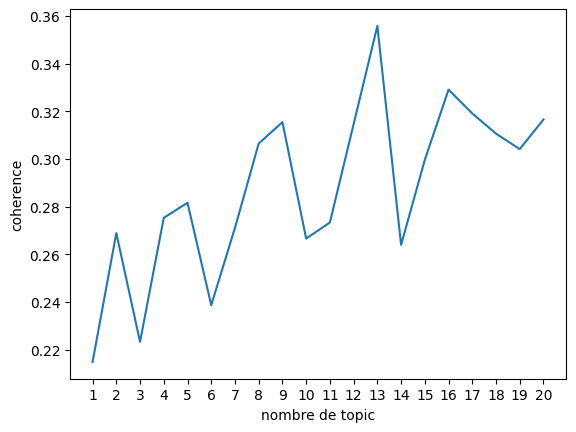

13


In [114]:
#Visualisation du résultat de l'expérience

plt.plot(nombres_de_topics,coherences)
plt.ylabel('coherence')
plt.xlabel('nombre de topic')
plt.xticks(nombres_de_topics)
plt.show()

### Création ou load du modèle

In [99]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics = 13, id2word = dictionary)

In [5]:
lda_model= gensim.models.LdaMulticore.load("./lda_best")

### Cohérence du modèle

In [116]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_par_jour, dictionary=dictionary)
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.3558736123085947


### Visualisation du modèle

In [74]:
#Pour la visualisation dataframe

topics = lda_model.show_topics(num_topics=16, num_words=10, formatted=True)
topics.sort()
df_topics={}
for nombre, mots in topics :
    row_topic=[]
    for mot in mots.split("+") :
        if len(row_topic)==10 :break
        mot=mot.split("*")[0]+" = "+mot.split('"')[1].split()[0]
        row_topic.append(mot)
    df_topics[nombre]=row_topic

In [75]:
df_topic_model = pd.DataFrame(df_topics)
df_topic_model.rename(index = {0: "Topic 1", 1: "Topic 2", 2: "Topic 3", 3: "Topic 4", 4: "Topic 5", 5: "Topic 6", 6: "Topic 7", 7: "Topic 8", 8: "Topic 9", 9: "Topic 10", 10: "Topic 11",11: "Topic 12", 12: "Topic 13"})

0                  1                    2   \
Topic 1      0.011 = tribune    0.013 = tribune      0.009 = rapport   
Topic 2      0.010 = mission       0.013 = pays        0.009 = route   
Topic 3          0.009 = cas       0.010 = euro      0.008 = enquête   
Topic 4     0.007 = pratique       0.010 = prix        0.008 = avion   
Topic 5        0.007 = ville     0.010 = guerre       0.008 = partie   
Topic 6        0.006 = crise    0.010 = million        0.007 = monde   
Topic 7          0.006 = cri        0.009 = gaz         0.007 = film   
Topic 8     0.006 = question   0.008 = milliard     0.006 = décembre   
Topic 9    0.005 = tradition      0.008 = santé   0.006 = commission   
Topic 10    0.005 = histoire    0.008 = énergie         0.006 = mort   

                         3                    4                5   \
Topic 1       0.018 = livre        0.019 = femme     0.010 = tour   
Topic 2    0.010 = écrivain          0.013 = vie   0.010 = guerre   
Topic 3        0.010 = mort     0.011 = festival   0.008 = groupe   
Topic 4       0.009 = roman        0.010 = objet     0.007 = pays   
Topic 5      0.008 = auteur        0.007 = œuvre    0.007 = image   
Topic 6    0.008 = histoire   0.007 = population      0.007 = vie   
Topic 7     0.008 = tribune      0.007 = octobre     0.006 = août   
Topic 8     0.007 = travail       0.006 = samedi    0.006 = mètre   
Topic 9         0.007 = âge          0.006 = île    0.006 = parti   
Topic 10     0.006 = guerre       0.006 = voyage    0.006 = année   

                            6                   7                      8   \
Topic 1         0.013 = guerre    0.012 = candidat         0.012 = député   
Topic 2      0.011 = président       0.012 = monde        0.011 = enquête   
Topic 3        0.009 = tribune       0.011 = coupe        0.011 = rapport   
Topic 4          0.008 = crise        0.010 = face      0.010 = président   
Topic 5     0.007 = entreprise    0.010 = élection   0.010 = gouvernement   
Topic 6           0.006 = face        0.009 = pays       0.010 = ministre   
Topic 7    0.006 = journaliste   0.009 = président      0.010 = assemblée   
Topic 8           0.006 = prix        0.008 = etat        0.008 = semaine   
Topic 9          0.006 = poche        0.007 = chef       0.007 = histoire   
Topic 10     0.006 = chronique      0.006 = équipe          0.006 = monde   

                         9                     10                    11  \
Topic 1      0.011 = procès       0.015 = tribune        0.017 = guerre   
Topic 2     0.011 = affaire    0.009 = changement          0.010 = film   
Topic 3    0.010 = mercredi     0.008 = recherche        0.008 = groupe   
Topic 4        0.009 = film   0.008 = journaliste          0.008 = pays   
Topic 5        0.008 = mois         0.007 = année          0.007 = face   
Topic 6     0.008 = missile         0.006 = monde   0.006 = réalisateur   
Topic 7      0.008 = prison      0.006 = sanction        0.006 = chaîne   
Topic 8      0.007 = cinéma          0.005 = euro      0.006 = ministre   
Topic 9       0.006 = année       0.005 = société         0.006 = monde   
Topic 10       0.006 = chef           0.005 = vie      0.005 = football   

                         12  
Topic 1     0.012 = migrant  
Topic 2    0.009 = vendredi  
Topic 3     0.009 = journée  
Topic 4         0.008 = fin  
Topic 5      0.007 = groupe  
Topic 6       0.007 = monde  
Topic 7      0.006 = projet  
Topic 8     0.006 = défense  
Topic 9     0.006 = million  
Topic 10   0.006 = discours

In [83]:
#Visualisation html des topics

pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary, mds='mmds')
# si on veut sauvegarder le graphique : 
#graphique = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary, mds='mmds')
#pyLDAvis.save_html(graphique, 'lda_13_sans_regroupement.html')

/mnt/c/Users/elisa/Downloads/Apprentissage automatique/envVirtu/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.101104  0.182274       1        1  12.339198
3      0.050774 -0.110657       2        1   8.933670
11    -0.046123  0.114298       3        1   8.546923
6     -0.009934  0.025424       4        1   8.239397
7     -0.168479  0.045369       5        1   8.047508
9      0.072880  0.099878       6        1   7.655738
10     0.158655  0.034571       7        1   7.284779
8     -0.103406 -0.029390       8        1   7.191108
4      0.097050 -0.177798       9        1   6.672799
5      0.112274  0.164048      10        1   6.392508
12    -0.087397 -0.180449      11        1   6.375923
2     -0.156498 -0.103428      12        1   6.257467
0      0.181308 -0.064140      13        1   6.062981, topic_info=           Term         Freq        Total Category  logprob  loglift
808       femme  3630.000000  3630.000000  Default  30.0000  30.0000
519       livre  4238.000000  4238.000000  Default  29.0000  29.0000
474     migrant  1334.000000  1334.000000  Default  28.0000  28.0000
766    festival  2543.000000  2543.000000  Default  27.0000  27.0000
466      procès  1663.000000  1663.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
406     service   328.410946  2344.132256  Topic13  -5.4757   0.8376
179        etat   310.581708  4998.811714  Topic13  -5.5315   0.0245
719       match   290.874475  1557.526140  Topic13  -5.5971   1.1250
1010  politique   292.014617  2742.345722  Topic13  -5.5932   0.5632
1657      santé   290.201486  2798.687616  Topic13  -5.5994   0.5366

[1144 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
5059     11  0.989601   abondance
3597      1  0.008233  abonnement
3597      5  0.004117  abonnement
3597      6  0.004117  abonnement
3597      7  0.568106  abonnement
...     ...       ...         ...
333       9  0.254064       œuvre
333      10  0.032028       œuvre
333      11  0.081370       œuvre
333      12  0.048043       œuvre
333      13  0.103010       œuvre

[5902 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 12, 7, 8, 10, 11, 9, 5, 6, 13, 3, 1])

### Intégration topic dans dataframe

In [6]:
data_df = pd.DataFrame(data, columns = ['Date','Articles'])
print(data_df.head())

         Date                                           Articles
0  2022-01-01  laboratoire ciel paradis île chercheur cadre é...
1  2022-01-01  science humanité aventure progrès monde podcas...
2  2022-01-01  mort chercheur père sociobiologie défenseur bi...
3  2022-01-01  science science école enseignement manquement ...
4  2022-01-01  réponse question astronaute français station i...


In [7]:
#Ajout du topic pour chaque document

get = lda_model.get_document_topics(bow_corpus)
#ici on a le topic pour chaque document
topic_doc=[]
for topics in get :
    if len(topics) > 1 : topic_doc.append(max(topics)[0])
    else : topic_doc.append(topics[0][0])

In [8]:
data_df['topics'] = topic_doc
print(data_df.head())

         Date                                           Articles  topics
0  2022-01-01  laboratoire ciel paradis île chercheur cadre é...       3
1  2022-01-01  science humanité aventure progrès monde podcas...      10
2  2022-01-01  mort chercheur père sociobiologie défenseur bi...       4
3  2022-01-01  science science école enseignement manquement ...      11
4  2022-01-01  réponse question astronaute français station i...      11


In [9]:
#Transformation des catégories en catégories ayant format apprécié par le modèle de prédiction

y = to_categorical(data_df['topics'].values)
y, y.shape

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 (112545, 13))

In [10]:
#Corpus pour le train

X = data_df['Articles']
X, X.shape

(0         laboratoire ciel paradis île chercheur cadre é...
 1         science humanité aventure progrès monde podcas...
 2         mort chercheur père sociobiologie défenseur bi...
 3         science science école enseignement manquement ...
 4         réponse question astronaute français station i...
                                 ...                        
 112540    centrafricain sentiment dakar radioscopie rela...
 112541    crise mot décideur rapidité bouleversement mon...
 112542    joueur rupture brésilien équipe football divor...
 112543    face arbitraire dirigeant réseau démocratie pr...
 112544    mort historien amour poème langue poète écriva...
 Name: Articles, Length: 112545, dtype: object,
 (112545,))

# LSTM

### Split en test/train

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10)
print(X_train, X_test, y_train, y_test)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

86906    maison habitant asphyxie témoignage habitant j...
25982    inflation dette pénurie guerre vulnérabilité é...
75355    etat membre mission formation soldat face beso...
62702    après-draghi européen président conseil turbul...
64571    histoire révolution cri société actualité hist...
                               ...                        
67591    avortement etat interruption grossesse etat or...
66651    comédien famille acteur réalisateur réplique a...
83581    maire projet budget collectivité projet loi fi...
31202    etats-unis crime armée chef fake accusation em...
81011    prud’homme licenciement commentateur commentat...
Name: Articles, Length: 101290, dtype: object 12088    crainte innovation besoin réglementation crypt...
13686    cité espace lune solder crise parc vocation ép...
87464    pharmacie charge mal place cabinet cabinet off...
26931    programme candidat élection promesse candidat ...
82426    dette marché investisseur observateur taux emp...
          

((101290,), (11255,), (101290, 13), (11255, 13))

### Deux manières de faire le mapping entre le dictionnaire de mot et sa représentation en nombre
Version obsolète Tokenizer et version plus récente TextVectorization. Ils ne gardent pas exactement le même nombre de mots dans leur dictionnaire. TextVectorization en garde plus ça peut être intéressant de garder le maximum de mots.

In [12]:
#pour savoir à quel padding fixer le x_train et x_test
max=0
for x in X_train :
    if len(x) > max :
        max= len(x)
print(max)

270


In [20]:
#version Tokenizer

max_words = 1001
max_len = 1000
tok = Tokenizer()
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max)

In [41]:
sequences_matrix[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [45]:
print(len(tok.word_index))

14170


In [ ]:
#version TextVectorization

vectorizer = TextVectorization(split="whitespace", output_mode="int")
vectorizer.adapt(X_train)
sequences = vectorizer(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max)

2023-05-20 19:17:25.851669: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
print(vectorizer.vocabulary_size())

14604


In [53]:
sequences_matrix[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### save/load du textvectorization et du texte vectorisé

In [29]:
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump({'config': vectorizer.get_config(), 'weights': vectorizer.get_weights()},f) 
with open('sequences_matrix.pkl', 'wb') as f:
    pickle.dump(sequences_matrix,f)

In [30]:
with open('vectorizer.pkl', 'rb') as f:
    pre_vectorizer=pickle.load(f) 
    vectorizer=TextVectorization.from_config(pre_vectorizer['config'])
    vectorizer.set_weights(pre_vectorizer['weights'])
with open('sequences_matrix.pkl', 'rb') as f:
    sequences_matrix=pickle.load(f)

In [31]:
print(vectorizer.vocabulary_size())

14604


In [32]:
sequences_matrix[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### Création du modèle

In [62]:
def model():
    
    model = Sequential()
    model.add(Input(name='inputs',shape=[max,]))
    model.add(Embedding(input_dim=vectorizer.vocabulary_size(), input_length=max, output_dim=50))
    model.add(LSTM(units = 128, return_sequences = True))
    model.add(Dropout(rate=0.5))
    model.add(LSTM(units = 128))
    model.add(Dropout(rate=0.5))
    model.add(Dense(13,activation="softmax"))    
        
    return model

In [63]:
model = model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 270, 50)           730200    
                                                                 
 lstm_6 (LSTM)               (None, 270, 128)          91648     
                                                                 
 dropout_6 (Dropout)         (None, 270, 128)          0         
                                                                 
 lstm_7 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 13)                1677      
                                                                 
Total params: 955,109
Trainable params: 955,109
Non-tr

### Train du modèle

In [64]:
# Choix d'un earlystopping pour que le modèle s'arrête lorsque la loss ne descend plus vraiment
keras_callback = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30),ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min',save_best_only=True)]

# Choix de la backpropagation pour notre classification binaire
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train du modèle
letrainbest = model.fit(sequences_matrix, y_train, batch_size=32, epochs=10, validation_split=0.2, callbacks=keras_callback, verbose=1)

Epoch 1/10
2533/2533 [==============================] - 1683s 661ms/step - loss: 2.4214 - accuracy: 0.1892 - val_loss: 2.3964 - val_accuracy: 0.1920
Epoch 2/10
2533/2533 [==============================] - 1691s 668ms/step - loss: 2.4009 - accuracy: 0.1900 - val_loss: 2.3927 - val_accuracy: 0.1920
Epoch 3/10
2533/2533 [==============================] - 1698s 671ms/step - loss: 2.3859 - accuracy: 0.1900 - val_loss: 2.3974 - val_accuracy: 0.1926
Epoch 4/10
2533/2533 [==============================] - 1626s 642ms/step - loss: 2.3712 - accuracy: 0.1909 - val_loss: 2.3915 - val_accuracy: 0.1942
Epoch 5/10
2533/2533 [==============================] - 1222s 482ms/step - loss: 2.3551 - accuracy: 0.1922 - val_loss: 2.4048 - val_accuracy: 0.1937
Epoch 6/10
2533/2533 [==============================] - 740s 292ms/step - loss: 2.3390 - accuracy: 0.1926 - val_loss: 2.4014 - val_accuracy: 0.1927
Epoch 7/10
2533/2533 [==============================] - 722s 285ms/step - loss: 2.3226 - accuracy: 0.1936 -

## Evaluation du modèle

/tmp/ipykernel_23120/162276019.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epoch, accuracy,"b",label="accuracy",color="turquoise")
/tmp/ipykernel_23120/162276019.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epoch, loss,"b",label="loss",color="tomato")


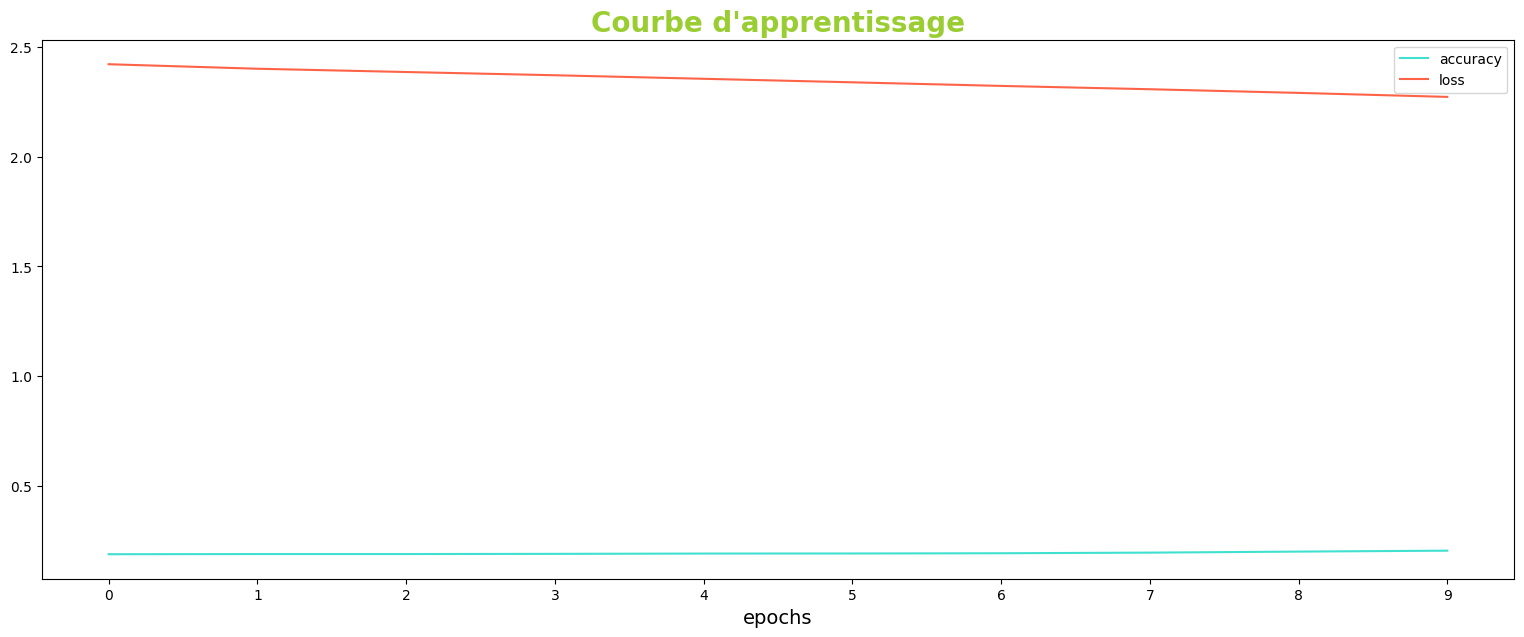

/tmp/ipykernel_23120/162276019.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epoch, val_accuracy,"b",label="val_accuracy",color="turquoise")
/tmp/ipykernel_23120/162276019.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epoch, val_loss,"b",label="val_loss",color="tomato")


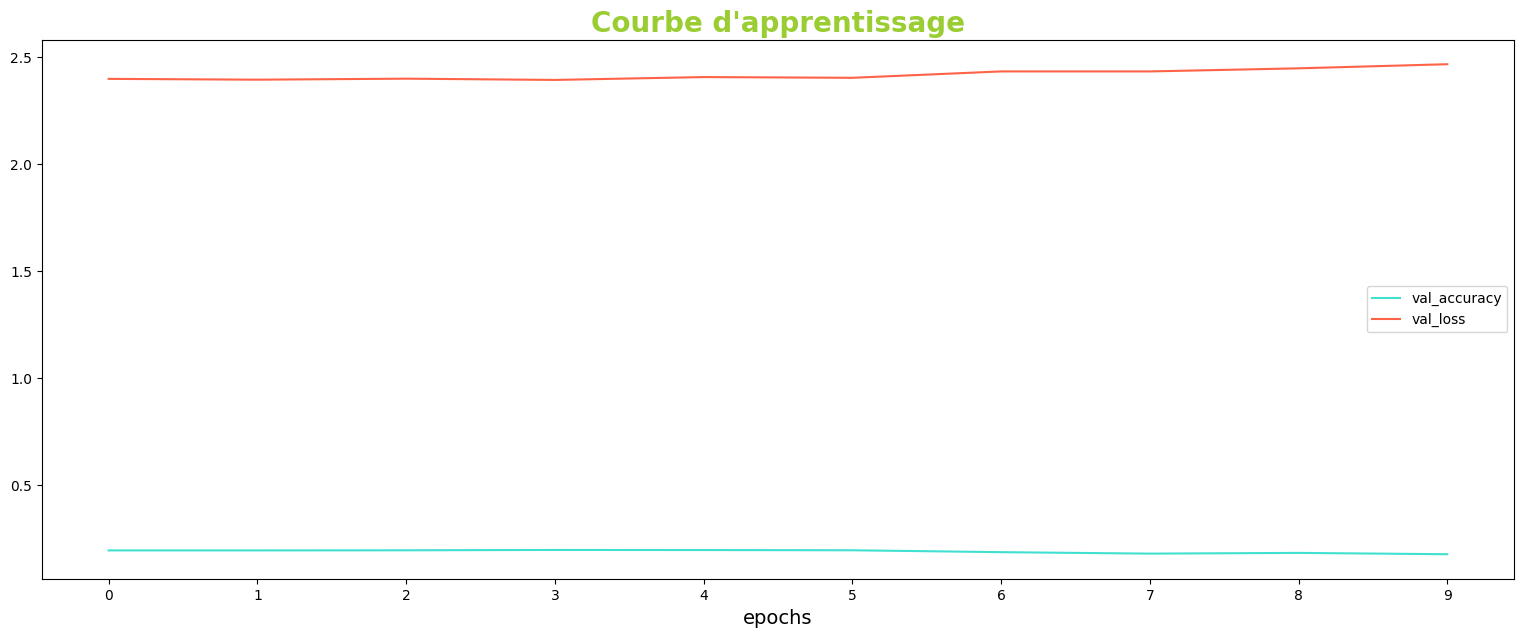

In [79]:
#Affichage de la courbe d'apprentissage
accuracy = letrainbest.history['accuracy'] # liste de toutes les accuracy au fil des epochs
loss = letrainbest.history['loss'] # liste de toutes les loss au fil des epochs
epoch = range(len(accuracy))

# si jamais on veut voir la courbe pour la validation
val_accuracy = letrainbest.history["val_accuracy"] # liste de toutes les validations accuracy au fil des epochs
val_loss = letrainbest.history["val_loss"] # liste de toutes les validations loss au fil des epochs

plt.figure(figsize=(19,7))
plt.plot(epoch, accuracy,"b",label="accuracy",color="turquoise")
plt.plot(epoch, loss,"b",label="loss",color="tomato")
plt.title("Courbe d'apprentissage",fontsize=20,fontweight="bold",color="yellowgreen")
plt.xlabel('epochs',fontsize=14)
plt.xticks(range(len(epoch)))
plt.legend()
plt.show()

plt.figure(figsize=(19,7))
plt.plot(epoch, val_accuracy,"b",label="val_accuracy",color="turquoise")
plt.plot(epoch, val_loss,"b",label="val_loss",color="tomato")
plt.title("Courbe d'apprentissage",fontsize=20,fontweight="bold",color="yellowgreen")
plt.xlabel('epochs',fontsize=14)
plt.xticks(range(len(epoch)))
plt.legend()
plt.show()

In [66]:
# Affichage des scores du modèle
bestmodel = keras.models.load_model('./best_model.h5')
sequences = vectorizer(X_test)
sequences_matrix_test = pad_sequences(sequences,maxlen=max)
bestmodel_scores = bestmodel.evaluate(sequences_matrix_test,y_test)
print('Test loss:', bestmodel_scores[0])
print('Test accuracy:', bestmodel_scores[1])

352/352 [==============================] - 36s 102ms/step - loss: 2.3959 - accuracy: 0.1890
Test loss: 2.3958818912506104
Test accuracy: 0.18898268043994904


In [68]:
pred_test = bestmodel.predict(sequences_matrix_test)

352/352 [==============================] - 36s 102ms/step


array([[0.01837719, 0.05400025, 0.03284795, ..., 0.10998588, 0.12626788,
        0.16880181],
       [0.0072388 , 0.03906622, 0.01488092, ..., 0.13357584, 0.15017788,
        0.21640918],
       [0.01655   , 0.04926305, 0.03199041, ..., 0.10928272, 0.12616117,
        0.18335299],
       ...,
       [0.01330995, 0.04863903, 0.02469898, ..., 0.12021176, 0.13796894,
        0.18543985],
       [0.01355836, 0.04826032, 0.02555446, ..., 0.11865666, 0.13614464,
        0.18722735],
       [0.01109762, 0.04583574, 0.02104686, ..., 0.12521145, 0.14334364,
        0.19388849]], dtype=float32)

In [69]:
y_pred_classes = np.argmax(pred_test, axis=1)
y_true = np.argmax(y_test, axis=1)

In [70]:
pd.crosstab(np.argmax(y_test, axis=1), np.argmax(pred_test, axis=1), rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted    9     12    All
Actual                      
0            8    224    232
1            1    476    477
2           29    398    427
3            7    553    560
4           14    513    527
5            3    543    546
6            5    756    761
7           10    841    851
8           25    924    949
9           41   1016   1057
10           8   1250   1258
11          19   1477   1496
12          28   2086   2114
All        198  11057  11255

Visualisation des résultats avec un grain plus fin :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       232
           1       0.00      0.00      0.00       477
           2       0.00      0.00      0.00       427
           3       0.00      0.00      0.00       560
           4       0.00      0.00      0.00       527
           5       0.00      0.00      0.00       546
           6       0.00      0.00      0.00       761
           7       0.00      0.00      0.00       851
           8       0.00      0.00      0.00       949
           9       0.21      0.04      0.07      1057
          10       0.00      0.00      0.00      1258
          11       0.00      0.00      0.00      1496
          12       0.19      0.99      0.32      2114

    accuracy                           0.19     11255
   macro avg       0.03      0.08      0.03     11255
weighted avg       0.05      0.19      0.07     11255

accuracy :  0.18898267436

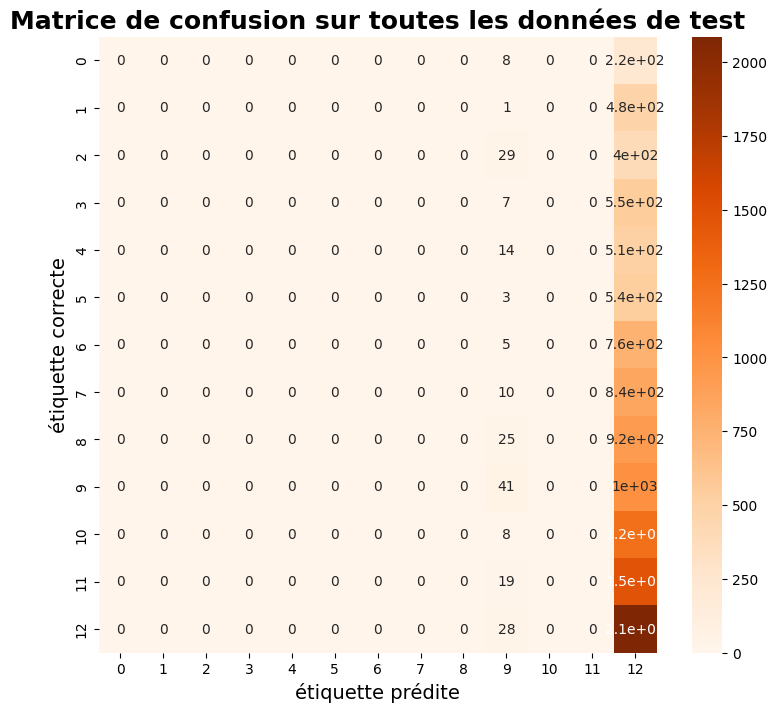

In [73]:
print("Visualisation des résultats avec un grain plus fin :\n",classification_report(y_true,y_pred_classes))
print("accuracy : ",accuracy_score(y_true,y_pred_classes))
print("précision : ",precision_score(y_true,y_pred_classes, average="micro"))
print("rappel : ",recall_score(y_true,y_pred_classes, average="micro"))

confusion_mtx = confusion_matrix(y_true,y_pred_classes)

f,ax = plt.subplots(figsize=(9,8))
sns.heatmap(confusion_mtx,annot=True,cmap="Oranges")
plt.title("Matrice de confusion sur toutes les données de test",fontsize=18,fontweight="bold")
plt.xlabel("étiquette prédite",fontsize=14)
plt.ylabel("étiquette correcte",fontsize=14)
plt.show()